In [1]:
from __future__ import division
from __future__ import print_function
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import pickle
import datetime
from IPython.display import HTML, display
from datetime import datetime
%matplotlib inline

# Homicide Data - Visualizations and Analysis
Using this definition https://www.fbi.gov/stats-services/publications/serial-murder#two, we know that a serial homicide deals with 2+ murdered victims and occur in separate events at different times. The goal of this notebook is to find visualize different combinations of murders in terms of victim and killer traits over time.  The first part of this notebook, we clean the data and get it ready.  The second part of this notebook, we use Folium to create simple maps of murder activity by state and city, and also use Seaborn to look at how murder compares to manslaughter, and weapon activity. Third, we begin to pick out some criteria that focus on unsolved murders and create a facet plot in Seaborn to visualize the trends in specific profiles of killings - like the increase/decrease of victims mal+ caucasian+18-24yo+killed by blunt object. 

# Data Cleaning

In [ ]:
data = pd.read_csv("/Users/catherineordun/Documents/scripts/data/database.csv")

In [ ]:
print("There are", len(data), "records.")

This is a nicely sized dataset with 638,454 records, consisting of 18 object variables and 6 integer variables a total of 24 variables. 

In [ ]:
print(data.dtypes.value_counts())
print(data.dtypes)

In [ ]:
print(data.head())

It would be a great to get a sense of size of the unique variables for each of those 18 object variables.  Let's get the unique category names of each object variable.  

In [ ]:
print("Number unique Agency Name vars", data['Agency Name'].nunique())
print("Number unique Agency Code vars", data['Agency Code'].nunique())
print("Number unique Agency Type vars", data['Agency Type'].nunique())
print("Number unique City", data['City'].nunique())
print("Number unique State", data['State'].nunique())
print("Number unique Month", data['Month'].nunique())
print("Number unique Crime Type", data['Crime Type'].nunique())
print("Number unique Crime Solved", data['Crime Solved'].nunique())
print("Number unique Victim Sex", data['Victim Sex'].nunique())
print("Number unique Victim Ethnicity", data['Victim Ethnicity'].nunique())
print("Number unique Perpetrator Sex", data['Perpetrator Sex'].nunique())
print("Number unique Perpetrator Age", data['Perpetrator Age'].nunique())
print("Number unique Perpetrator Race", data['Perpetrator Race'].nunique())
print("Number unique Relationship", data['Relationship'].nunique())
print("Number unique Weapon", data['Weapon'].nunique())
print("Number unique Record Source", data['Record Source'].nunique())


This is helpful because it gives us the sense of which features need to be formatted like 'Perpetrator Age' which we need to convert to int, which could be used as target variables like 'Victim Sex', 'Crime Type', 'Crime Solved', and which ones may not give us a lot of feature importance like 'Agency Code'. Let's get started.  

Let's take a look at a few random records just to get a sense of what the data looks like in a different format as opposed to the 'head' view. Let's look at Record ID 3 and 5000, below. 

In [ ]:
print(data.loc[2])

In [ ]:
print(data.loc[4999])

In [ ]:
print(data.loc[99999])

In these three cases, we notice that there will be cases of 'unknown' as categories.  Undoubtedly, this will raise its head again and it'll be important to understand how many 'unknowns' exist.  Also, 'Perpetrator Age' isn't always indicated, for Case ID 3 it was 0, so there will be instances where probably 0 = unknown, as well.  Let's first do some cleansing. 

<li> Change Year to datetime
<li> Convert to categorical: 'Agency Type', 'State', 'Month', 'Crime Type', 'Crime Solved', 'Victim Sex', 'Victim Race', 'Victim Ethnicity', 'Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Ethnicity', 'Relationship', 'Weapon', 'Record Source'
<li> Convert 'Perpetrator Age' to integer

In [ ]:
data2 = data.copy()

In [ ]:
data2.head()

In [ ]:
data2['Year'] = data2['Year'].astype(str)
data2['Month'] = data2['Month'].astype(str)
print(data2['Year'].unique())
print(data2['Month'].unique())

In [ ]:
data2['Date'] = data2['Month'] + " "+ data2['Year']
print(data2.head())

In [ ]:
#Convert the date into a single month-year
data2['Date'] = data2['Month'] + " " + data2['Year']
data2['Date_'] =  pd.to_datetime(data2['Date'], format='%B %Y')


In [ ]:
print(data2.dtypes)

In [ ]:
#Make sure it converted to only year datetimes
data2['Date_'].loc[:10]

In [ ]:
#Convert variables into categories 

def ascategory(cols, df):
	for col in cols:
		df[col] = df[col].astype('category')
all_cols = ['Agency Type',
            'State',
            'Month',
            'Crime Type', 
            'Crime Solved', 
            'Victim Sex', 'Victim Race', 
            'Victim Ethnicity', 
            'Perpetrator Sex', 
            'Perpetrator Race', 
            'Perpetrator Ethnicity', 
            'Relationship', 
            'Weapon',
            'Record Source'
]

ascategory(all_cols, data2)
print(data2.dtypes)

Sometimes converting objects to integers takes a little investigation.  First, let's see what the unique values are and if there are any 'nans' or ' ' spaces. We can see that there are some values that are blank indicated by the ' '.  So, we need to first convert the whole object variable into a string, then replace the spaces with the character '0' zero, and then cast into an integer. I'm checking the head of the df and dtypes along the way to make sure it's working. 

In [ ]:
data2['Perpetrator Age'].unique()

In [ ]:
data2.head(5)

In [ ]:
data2['Perpetrator Age'] = data2['Perpetrator Age'].astype(str)
data2['Perpetrator Age'] = data2['Perpetrator Age'].str.replace(' ', '0')
print(data2.dtypes)

In [ ]:
data2['Perpetrator Age'].unique()

In [ ]:
data2['Perpetrator Age'] = data2['Perpetrator Age'].astype(int)

In [ ]:
data2.dtypes

In [ ]:
data2.head()

<b><i>For me, pickle the data so I can run it again.</b></i>

In [2]:
#data2.to_pickle('homicide.pkl')
#read pickle
data2 = pd.read_pickle('homicide.pkl')

In [3]:
data2.dtypes

Record ID                         int64
Agency Code                      object
Agency Name                      object
Agency Type                    category
City                             object
State                          category
Year                             object
Month                          category
Incident                          int64
Crime Type                     category
Crime Solved                   category
Victim Sex                     category
Victim Age                        int64
Victim Race                    category
Victim Ethnicity               category
Perpetrator Sex                category
Perpetrator Age                   int64
Perpetrator Race               category
Perpetrator Ethnicity          category
Relationship                   category
Weapon                         category
Victim Count                      int64
Perpetrator Count                 int64
Record Source                  category
Date                             object


# Descriptive Analysis and Maps

<b>Create a chloropleth to visualize the counts of each type of Crime Type, Incident, Victim Count, Prepetrator Count, by State:</b>

In [1]:
import folium

In [145]:
#prepare two data sets 
#read in FIPS file and merge with data2
#get FIPS data from: https://www.census.gov/geo/reference/ansi_statetables.html
fips = pd.read_csv("/Users/catherineordun/Documents/scripts/fipscodes.csv")
fips.rename(index=str, columns={'Name':'State'}, inplace=True)
fips.head()

,State,FIPS_Code,USPS_State
0,Alabama,1,AL
1,Alaska,2,AK
2,Arizona,4,AZ
3,Arkansas,5,AR
4,California,6,CA


This dataframe contains the FIPS codes merged with the cleaned data2 frame: 'map_data'

In [146]:
#merge with data2 to get the state abbreviations
map_data = pd.merge(data2, fips, on="State", how='left')

In [147]:
map_data.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source,Date,Date_,meets_criteria,FIPS_Code,USPS_State
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,1,...,Acquaintance,Blunt Object,0,0,FBI,January 1980,1980-01-01,0,2.0,AK
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,1,...,Acquaintance,Strangulation,0,0,FBI,March 1980,1980-03-01,0,2.0,AK
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,1,...,Unknown,Unknown,0,0,FBI,March 1980,1980-03-01,1,2.0,AK
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,1,...,Acquaintance,Strangulation,0,0,FBI,April 1980,1980-04-01,0,2.0,AK
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,1,...,Unknown,Unknown,0,1,FBI,April 1980,1980-04-01,1,2.0,AK


<b>From the map_data, let's get an understanding of the distribution of two crime types by state to answer the question: How many Murder or Manslaughter for each state? How many Manslaughter by Negligence for each state? </b>

In [148]:
map_data['Crime Type'].unique()

array([1, 0])

First, I'd like to get the sum of all records for each state. 

In [149]:
map_counts = pd.pivot_table(map_data,index=["USPS_State"],values=["Record ID"],aggfunc=[len])
#reshape
mc1 = map_counts.reset_index()
mc1.columns.droplevel()
mc1.columns = ['State', 'Total']
mc1.head()

,State,Total
0,AK,1617
1,AL,11376
2,AR,6947
3,AZ,12871
4,CA,99783


In [150]:
map_crime = pd.pivot_table(map_data,index=["USPS_State", "Crime Type"],values=["Record ID"],aggfunc=[len])
map_crime.head()

len
                      Record ID
USPS_State Crime Type          
AK         0                123
           1               1494
AL         0                 45
           1              11331
AR         0                121

In [151]:
#reshape a little so Seaborn can read
mc2 = map_crime.reset_index()
mc2.columns = mc2.columns.droplevel()
mc2.columns = ['State', 'Crime Type', 'Count']
mc2['crime'] = pd.factorize(mc2['Crime Type'])[0]
mc2.head()

,State,Crime Type,Count,crime
0,AK,0,123,0
1,AK,1,1494,1
2,AL,0,45,0
3,AL,1,11331,1
4,AR,0,121,0


<b>Which states have the greatest number of 'Murder or Manslaughter', purely based on counts of records? </b>

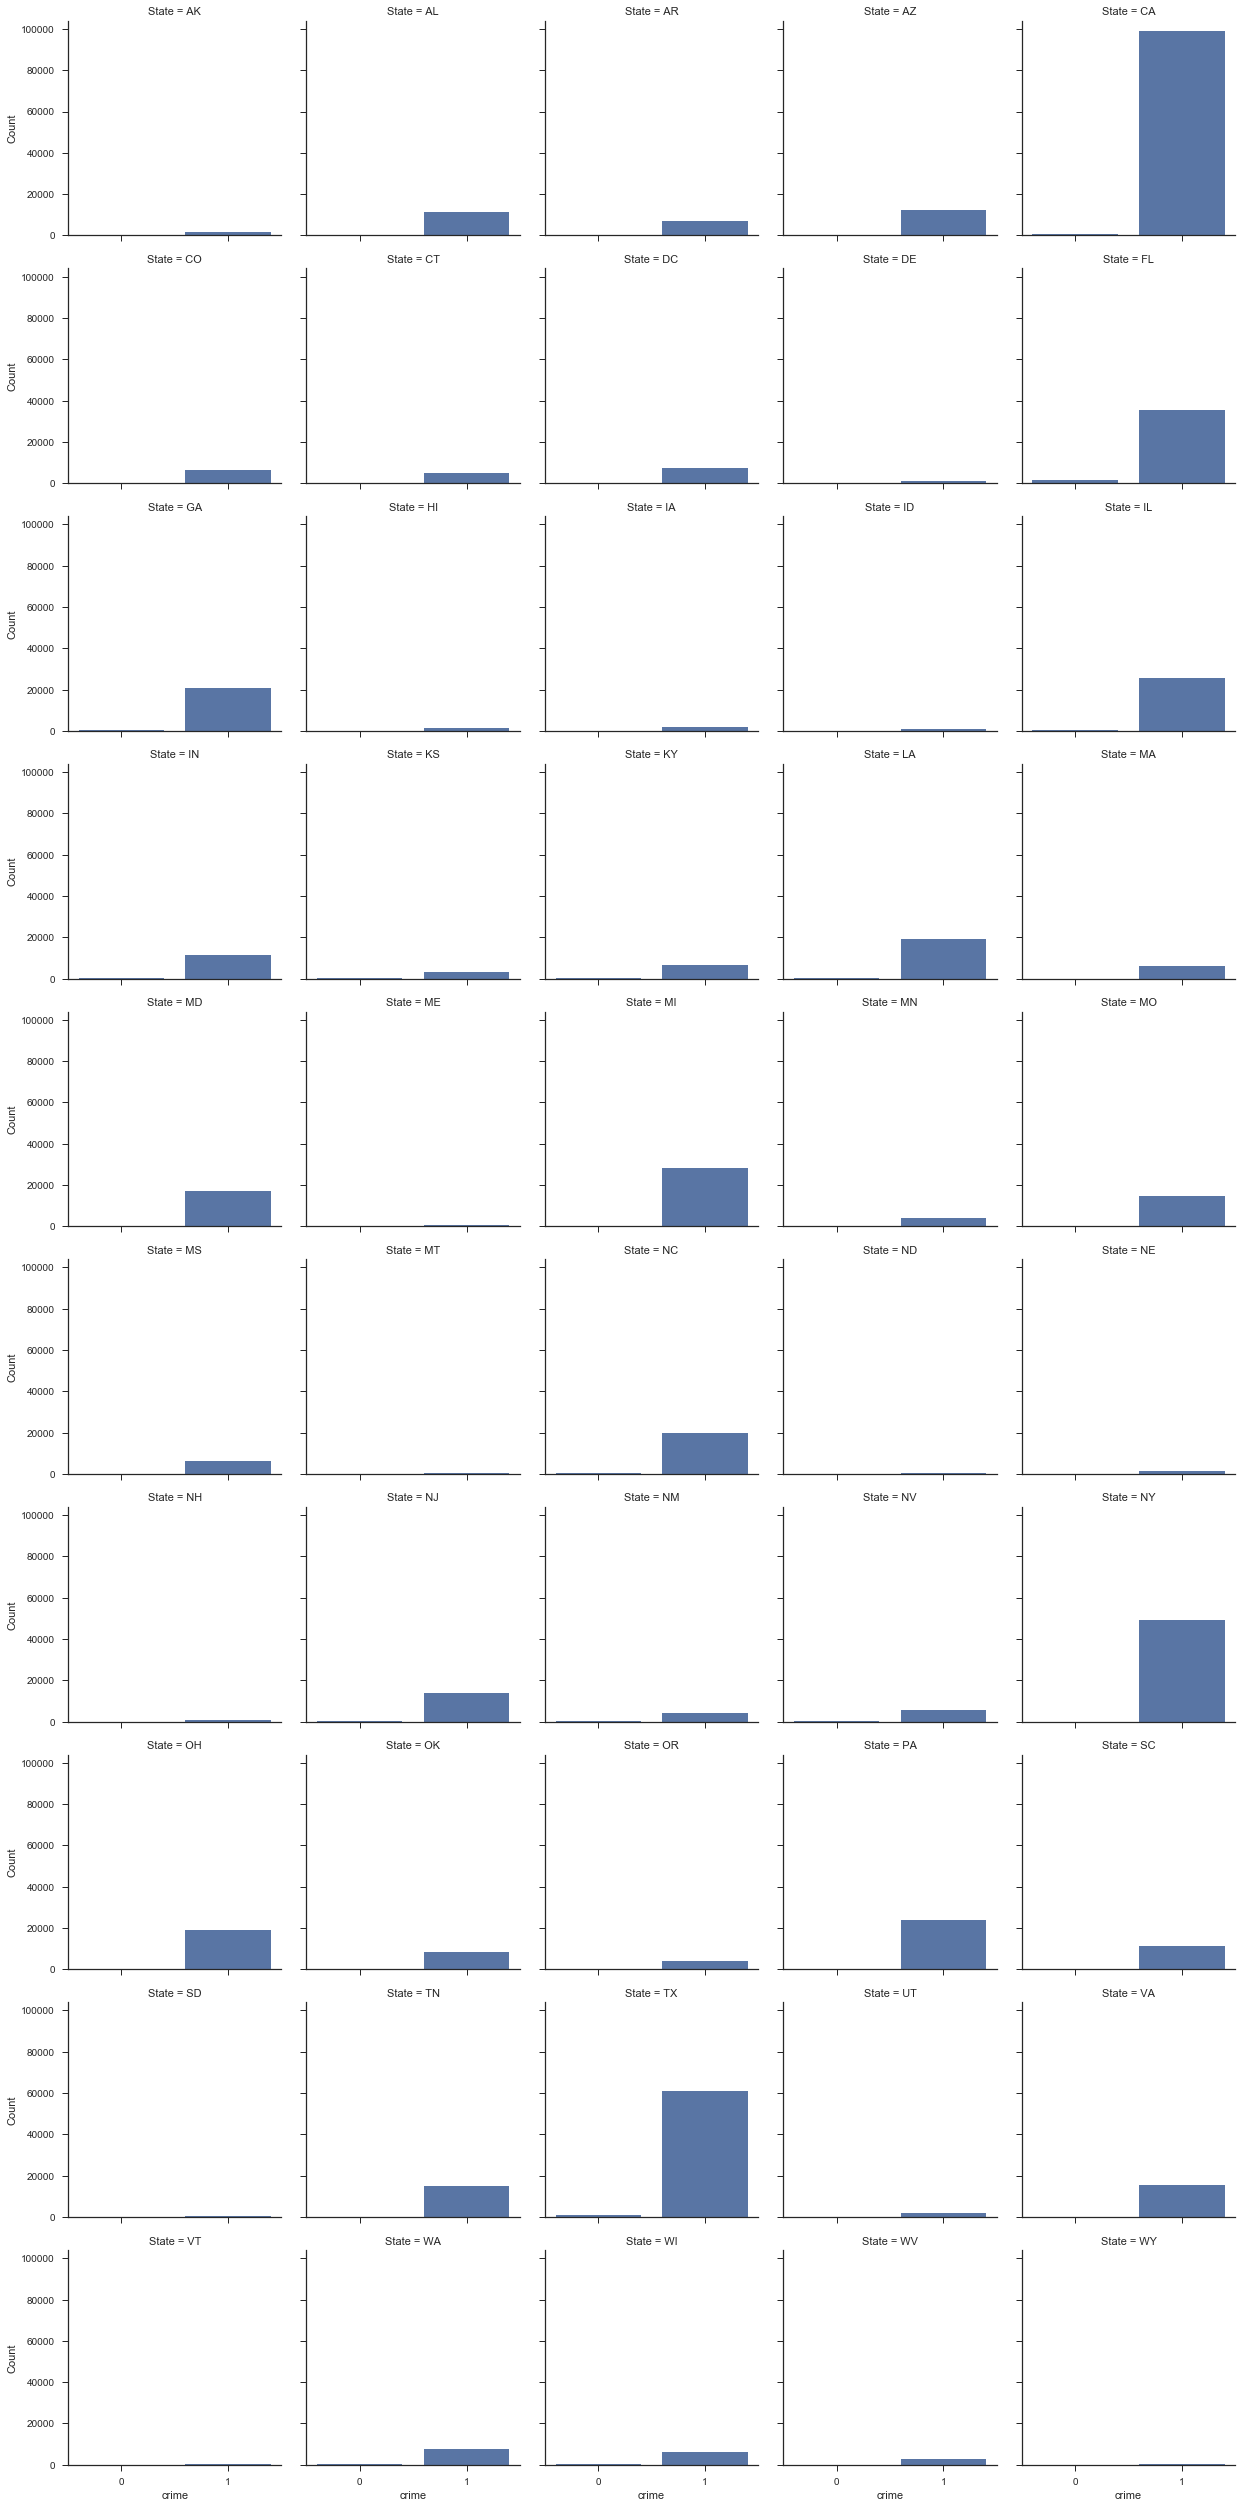

In [152]:
sns.set(style="ticks")
g = sns.FacetGrid(mc2, col="State", col_wrap=5, size=3.5)
g = g.map(sns.barplot, "crime", "Count")

In [153]:
crimecount = pd.merge(mc2, mc1, on='State')
crimecount['perc'] = crimecount['Count'] / crimecount['Total']
crimecount.head()

,State,Crime Type,Count,crime,Total,perc
0,AK,0,123,0,1617,0.076067
1,AK,1,1494,1,1617,0.923933
2,AL,0,45,0,11376,0.003956
3,AL,1,11331,1,11376,0.996044
4,AR,0,121,0,6947,0.017418


<b>How does'Murder or Manslaughter', compare to 'Manslaughter by Negligence', for each state based on the total percentage of all records during this time frame? </b> 

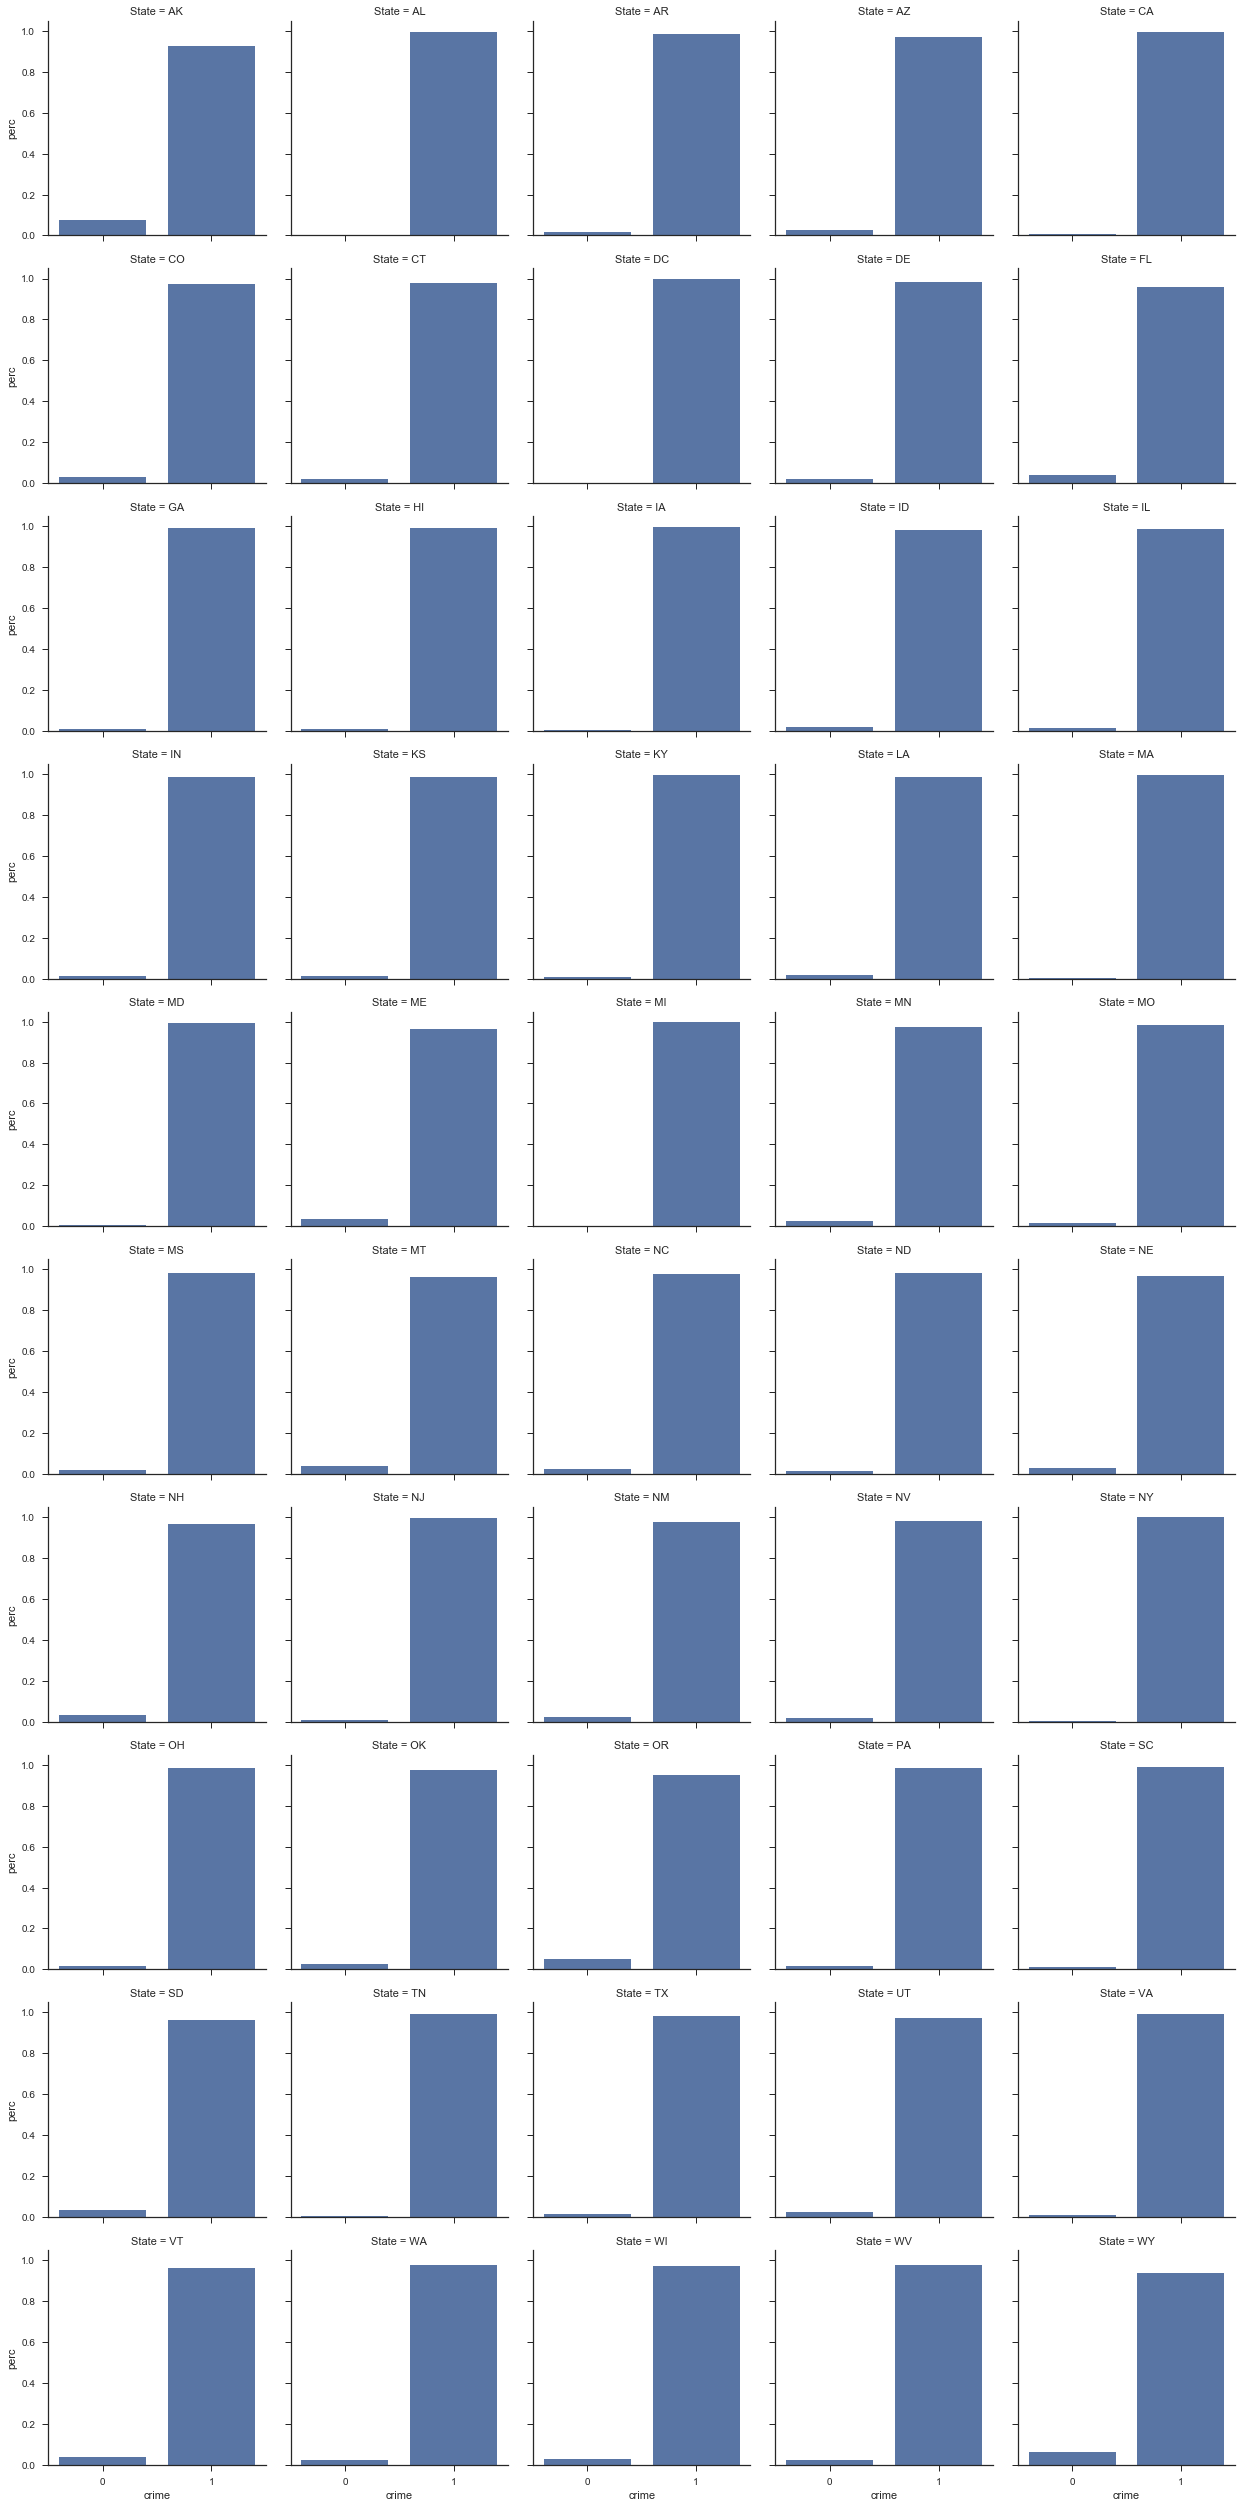

In [154]:
sns.set(style="ticks")
g = sns.FacetGrid(crimecount, col="State", col_wrap=5, size=3.5)
g = g.map(sns.barplot, "crime", "perc")


<b>Chloropleth Map by Case Count (Record ID)</b>  

In [155]:
d1 = mc1[['State', 'Total']].copy()
d2 = crimecount[['State', 'perc']].copy()


In [156]:
#You need to download the us-states.json file from 
#here: https://github.com/python-visualization/folium/tree/master/examples/data
state_geo = r'/Users/catherineordun/Documents/scripts/us-states.json'

In [157]:
#Let Folium determine the scale
map_1 = folium.Map(location=[48, -102], zoom_start=3)
map_1.choropleth(geo_path=state_geo, data=d1,
             columns=['State', 'Total'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='Total')

In [158]:
display(map_1)

<b>Top States for Murder</b>

In [159]:
((crimecount.loc[(crimecount['crime']==1)]).sort_values(by='perc', ascending=False)).head(10)

,State,Crime Type,Count,crime,Total,perc
15,DC,1,7110,1,7115,0.999297
45,MI,1,28425,1,28448,0.999192
69,NY,1,49222,1,49268,0.999066
3,AL,1,11331,1,11376,0.996044
39,MA,1,6008,1,6036,0.995361
41,MD,1,17208,1,17312,0.993993
25,IA,1,1738,1,1749,0.993711
83,TN,1,14832,1,14930,0.993436
63,NJ,1,14033,1,14132,0.992995
35,KY,1,6506,1,6554,0.992676


In [160]:
#Let Folium determine the scale
map_2 = folium.Map(location=[48, -102], zoom_start=3)
map_2.choropleth(geo_path=state_geo, data=(crimecount.loc[(crimecount['crime']==1)]),
             columns=['State', 'perc'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='perc')

In [161]:
display(map_2)

<b> Top Cities for Murder </b>

In [162]:
city_crime = pd.pivot_table(data2,index=["State", "City", "Crime Type"],values=["Record ID"],aggfunc=[len])
#reshape a little so Seaborn can read
cc = city_crime.reset_index()
cc.columns = cc.columns.droplevel()
cc.columns = ['State', 'City', 'Crime Type', 'Count']
cc['crime'] = pd.factorize(cc['Crime Type'])[0]
cc.head()

,State,City,Crime Type,Count,crime
0,Alabama,Abbeville,0,NaN,0
1,Alabama,Abbeville,1,NaN,1
2,Alabama,Acadia,0,NaN,0
3,Alabama,Acadia,1,NaN,1
4,Alabama,Accomack,0,NaN,0


In [163]:
state_totals = pd.pivot_table(data2,index=["State"],values=["Record ID"],aggfunc=[len])
#reshape
tot = state_totals.reset_index()
tot.columns.droplevel()
tot.columns = ['State', 'Total']
tot.dtypes

cc_fin = pd.merge(cc, tot, on='State', how='left')
cc_fin['perc'] = cc_fin['Count'] / cc_fin['Total']
cc_fin.head()

,State,City,Crime Type,Count,crime,Total,perc
0,Alabama,Abbeville,0,NaN,0,11376,NaN
1,Alabama,Abbeville,1,NaN,1,11376,NaN
2,Alabama,Acadia,0,NaN,0,11376,NaN
3,Alabama,Acadia,1,NaN,1,11376,NaN
4,Alabama,Accomack,0,NaN,0,11376,NaN


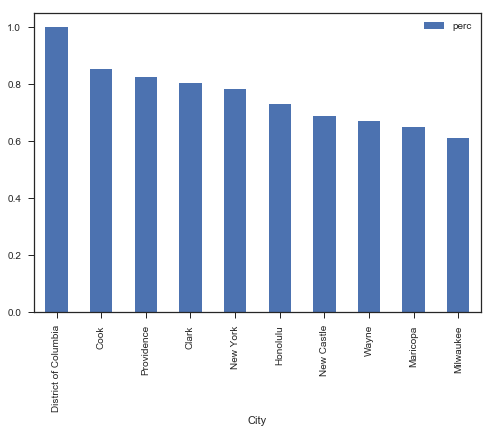

In [164]:
#Top 10 cities by percentage of all crimes as crime type "Murder or Manslaughter"
cities = (cc_fin.loc[(cc_fin['crime']==1)])
((cities.sort_values(by='perc', ascending=False)).head(10)).plot(x='City', y='perc', kind='bar')

<b> Let's explore the weapons and any trends in how they've been used in crimes has changed from year to year. </b>

In [165]:
crime_time = pd.pivot_table(data2,index=["Year", "Weapon"],values=["Record ID"],aggfunc=[len])

In [166]:
crime_time.reset_index(inplace=True)
crime_time.columns.droplevel()
crime_time.columns = ['Year', 'Weapon', 'Count']
crime_time.dtypes

Year        object
Weapon    category
Count      float64
dtype: object

In [167]:
crime_time['Year'] = pd.factorize(crime_time['Year'])[0]
crime_time.head()

,Year,Weapon,Count
0,0,Blunt Object,2397.0
1,0,Drowning,50.0
2,0,Drugs,14.0
3,0,Explosives,22.0
4,0,Fall,17.0


Factor Plot to show use of weapons over time

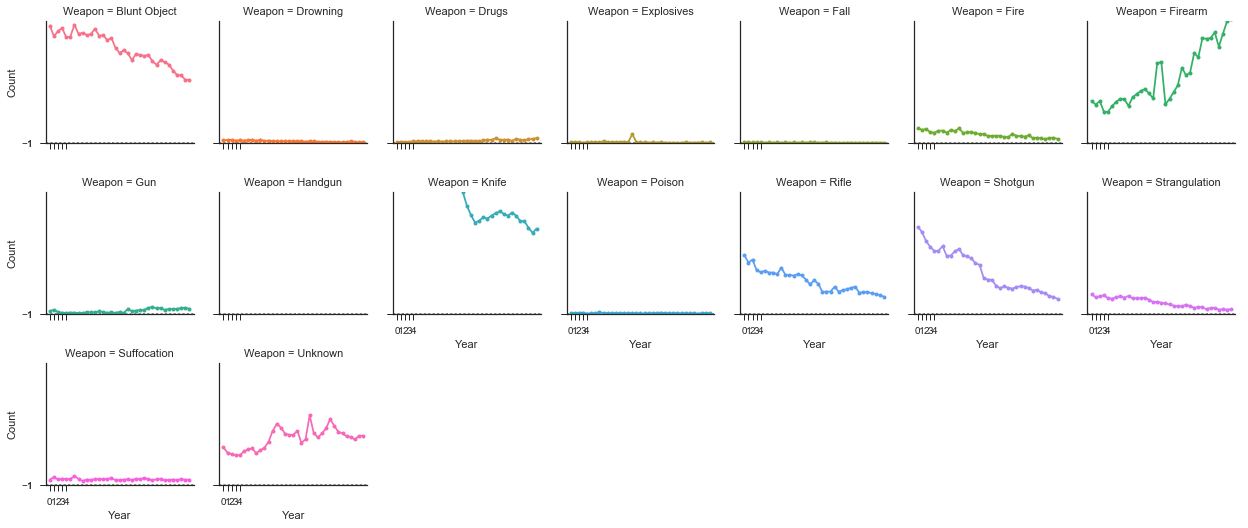

In [139]:
# Create a dataset with many short random walks
rs = np.random.RandomState(4)
pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
pos -= pos[:, 0, np.newaxis]
step = np.tile(range(5), 20)
walk = np.repeat(range(20), 5)

sns.set(style="ticks")
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(crime_time, col="Weapon", hue="Weapon", col_wrap=7, size=2.5)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=.5, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "Year", "Count", marker="o", ms=4)

# Adjust the tick positions and labels
#xlim is the years factorized from 0 to 34 
grid.set(xticks=np.arange(5), yticks=[-1, 1],
         xlim=(-1, 35), ylim=(0, 2500))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1.15)


Use of firearms as a weapon has steadily increased form 1980 to 2014, and notice how 'Gun' has also increased, which should really be rolled up into 'Firearm'. Weapons like 'Rifle' and 'Shotgun' should also be folded under 'Firearm' possibly. But, we can see that the number of crimes committed using 'Knife' and 'Blunt Object' are high in count.  The 'Unknown' weapon type has also increased over the years. 


# Coding different combinations

It makes sense that solved crimes with known perpetrators (sex, age, ethnicity, race) are not serial killers still at-large.  After narrowing down the population to unsolved cases, we could create a "profile" code of different combinations of victim sex-age-race-ethnicity-age and identify which codes have been repeated several times across time and also across nearby geographic cities. This may give us a sense of repetitive patterns of murders, where certain profiles of victims have been killed in the same way.  

Let's outline some basic criteria where we'd like to focus on a subset of data that has these features: 

<li> Crime == Not solved
<li> Crime == Murder or Manslaughter
<li> Perpetrator Sex, Age, Race, Ethnicity == Unknown
<li> Relationship == Unknown
<li> Weapon could be any type
<li> Victim Count could be any number

With these conditions met, we can create a population of unsolved crimes to focus on. 

In [4]:
data2['Crime Solved'].unique()

[Yes, No]
Categories (2, object): [Yes, No]

In [5]:
data2['Crime Solved'] = data2['Crime Solved'].map({'Yes': 1, 'No':0})

In [6]:
data2['Crime Type'] = data2['Crime Type'].map({'Murder or Manslaughter': 1, 'Manslaughter by Negligence':0})

In [7]:
print(data2['Perpetrator Sex'].unique())
print(data2['Perpetrator Age'].unique())
print(data2['Perpetrator Race'].unique())
print(data2['Perpetrator Ethnicity'].unique())

[Male, Unknown, Female]
Categories (3, object): [Male, Unknown, Female]
[15 42  0 36 27 35 40 49 39 29 19 23 33 26 41 28 61 25  7 17 34 21 43 38 66
 32 37 22 30 24 65 51 60 45 64 18 20 44 73 62 69 52 16 90 56 47 57 31 46 14
 55 50 54 68 77 53 67 48 76 58 71 63 89 13 75 72 93 59 10 11 79 74 99 70 78
 80  9 12 81  6 87 82 83  8 84 85 86  5  3  1 88 95  4 91 92 96 94  2 98 97]
[Native American/Alaska Native, White, Unknown, Black, Asian/Pacific Islander]
Categories (5, object): [Native American/Alaska Native, White, Unknown, Black, Asian/Pacific Islander]
[Unknown, Not Hispanic, Hispanic]
Categories (3, object): [Unknown, Not Hispanic, Hispanic]


In [8]:
data2['meets_criteria'] = np.where(((data2['Crime Solved'] == 0) & 
                                   (data2['Crime Type'] == 1) &
                                   (data2['Perpetrator Sex'] == 'Unknown') &
                                   (data2['Perpetrator Age'] ==0) &
                                   (data2['Perpetrator Race'] == 'Unknown') &
                                   (data2['Perpetrator Ethnicity'] =='Unknown')),
                                   1, 0)
print(len((data2.loc[(data2['meets_criteria']== 1)])))

188835


In [9]:
print("This is", (len((data2.loc[(data2['meets_criteria']== 1)]))) / len(data2), "of the total cases.")

This is 0.295769154865 of the total cases.


Almost 30% of the cases meet our criteria, where the crime was not solved and the perpetrator was unknown. Let's drill into this set of the population to write a detection model. Let's start with some exploration of this population. Let's start by year and then by year and city. 

In [10]:
pop = (data2.loc[(data2['meets_criteria']== 1)])

In [11]:
pop.describe()

,Record ID,Incident,Crime Type,Crime Solved,Victim Age,Perpetrator Age,Victim Count,Perpetrator Count,meets_criteria
count,188835.000000,188835.000000,188835.0,188835.0,188835.000000,188835.0,188835.000000,188835.000000,188835.0
mean,325925.152615,25.377118,1.0,0.0,37.442757,0.0,0.101522,0.034369,1.0
std,180446.706058,87.727404,0.0,0.0,57.133447,0.0,0.431471,0.203199,0.0
min,3.000000,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.000000,1.0
25%,175900.000000,1.000000,1.0,0.0,22.000000,0.0,0.000000,0.000000,1.0
50%,326415.000000,4.000000,1.0,0.0,29.000000,0.0,0.000000,0.000000,1.0
75%,481334.000000,16.000000,1.0,0.0,41.000000,0.0,0.000000,0.000000,1.0
max,638450.000000,999.000000,1.0,0.0,998.000000,0.0,9.000000,8.000000,1.0


<b> View Number of Unsolved Murders by Date </b>

In [ ]:
pop_time = (pd.pivot_table(pop,index=["Date_"],values=["Record ID"],aggfunc=[len]))
pop_time.plot(figsize=(14,6))

In [ ]:
pop_time.sort_values(('len', 'Record ID'), ascending=False).head(10)

I found this part to be very interesting, which warrants a deep dive into time series analysis itself.  The number of unsolved cases reached a maximum in in December 1992. More analysis needs to be done here, but using seasonal decomposition, we can see that there is a seasonal trend in unsolved murders. Appears to be a pattern of rising crimes starting in late spring around June every year and hitting a peak in December, then falling at the beginning of each year. 

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = pop_time
result = seasonal_decompose(series, model='multiplicative')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(12, 6)
plt.show()

In [ ]:
result.seasonal

<b>Fluctuation in crimes from city to city.</b>

In [ ]:
pop_city = (pd.pivot_table(pop,index=["City"],
                           columns = "Year", 
                           values=["Record ID"],
                           aggfunc=lambda x: len(x)))
pop_city.fillna(value=0, inplace=True)
pop_city

In [ ]:
#normalized data frame across rows by their sums
df_norm = pop_city.div(pop_city.sum(axis=1), axis=0)

In [ ]:
#compute the standard deviation for each row
df_norm['std'] = (df_norm.std(axis=1))

In [ ]:
df_norm['mean'] = (df_norm.mean(axis=1))

In [ ]:
df_norm.head()

In [ ]:
#city_time = df_norm.transpose()
#city_time.head()

## Coding Continued - Sex / Age / Race / Ethnicity / Weapon 

"Profiles" means a single code that combines the Victim Sex / Age / Race / Ethnicity / Weapon, by the City and Date.  At the end of this notebook, I create a plot that counts up the number of each of these unique codes grouped by the Sex and Age Group (binned).  The goal of this exercise is to set up "mini signals" of specific types of murders at the national level.  Later, (note in this notebook), my goal is to bring this down to the state level so that I can trace murders of different profiles from county to county quarter to quarter. 


In [12]:
pop_victim_combos_2 = pop[['Victim Sex', 'Victim Age', 'Victim Race', 'Victim Ethnicity', 'Date_', 'City', 'State', 'Weapon', 'Record ID']].copy()

In [13]:
pvc_2 = pop_victim_combos_2.groupby(['State', 'Date_', 'City', 'Weapon', 'Victim Sex', 'Victim Race','Victim Ethnicity', 'Victim Age']).size()

In [14]:
pvc_2.head(10)

State    Date_       City        Weapon      Victim Sex  Victim Race  Victim Ethnicity  Victim Age
Alabama  1980-01-01  Cleburne    Handgun     Female      White        Unknown           63            1
                                                                                        77            1
                                             Male        White        Unknown           79            1
                                                                                        99            1
                     Limestone   Handgun     Female      White        Unknown           27            1
                     Mobile      Handgun     Male        White        Unknown           29            1
                     Tuscaloosa  Firearm     Male        White        Unknown           55            1
                     Walker      Explosives  Female      White        Unknown           28            1
         1980-02-01  Mobile      Firearm     Male        White       

In [15]:
pvc_fin = pvc_2.reset_index()

In [16]:
pvc_fin.dtypes

State                     category
Date_               datetime64[ns]
City                        object
Weapon                    category
Victim Sex                category
Victim Race               category
Victim Ethnicity          category
Victim Age                   int64
0                            int64
dtype: object

In [17]:
pvc_fin.head()

,State,Date_,City,Weapon,Victim Sex,Victim Race,Victim Ethnicity,Victim Age,0
0,Alabama,1980-01-01,Cleburne,Handgun,Female,White,Unknown,63,1
1,Alabama,1980-01-01,Cleburne,Handgun,Female,White,Unknown,77,1
2,Alabama,1980-01-01,Cleburne,Handgun,Male,White,Unknown,79,1
3,Alabama,1980-01-01,Cleburne,Handgun,Male,White,Unknown,99,1
4,Alabama,1980-01-01,Limestone,Handgun,Female,White,Unknown,27,1


In [18]:
pvc_fin['City'] = pd.factorize(pvc_fin['City'])[0]
print(pvc_fin['City'].nunique())
pvc_fin['Weapon'] = pd.factorize(pvc_fin['Weapon'])[0]
print(pvc_fin['Weapon'].nunique())
pvc_fin['Victim Sex'] = pd.factorize(pvc_fin['Victim Sex'])[0]
print(pvc_fin['Victim Sex'].nunique())
pvc_fin['Victim Race'] = pd.factorize(pvc_fin['Victim Race'])[0]
print(pvc_fin['Victim Race'].nunique())
pvc_fin['Victim Ethnicity'] = pd.factorize(pvc_fin['Victim Ethnicity'])[0]
print(pvc_fin['Victim Ethnicity'].nunique())

1497
16
3
5
3


In [19]:
pvc_fin.head()

,State,Date_,City,Weapon,Victim Sex,Victim Race,Victim Ethnicity,Victim Age,0
0,Alabama,1980-01-01,0,0,0,0,0,63,1
1,Alabama,1980-01-01,0,0,0,0,0,77,1
2,Alabama,1980-01-01,0,0,1,0,0,79,1
3,Alabama,1980-01-01,0,0,1,0,0,99,1
4,Alabama,1980-01-01,1,0,0,0,0,27,1


<b>Set up codes for each record</b>

In [20]:
x= pvc_fin.groupby(['State', 'Date_', 'City', 'Weapon', 'Victim Sex', 'Victim Race','Victim Ethnicity', 'Victim Age']).size()
x_ = x.reset_index()
print(x_)

          State      Date_  City  Weapon  Victim Sex  Victim Race  \
0       Alabama 1980-01-01     0       0           0            0   
1       Alabama 1980-01-01     0       0           0            0   
2       Alabama 1980-01-01     0       0           1            0   
3       Alabama 1980-01-01     0       0           1            0   
4       Alabama 1980-01-01     1       0           0            0   
5       Alabama 1980-01-01     2       0           1            0   
6       Alabama 1980-01-01     3       1           1            0   
7       Alabama 1980-01-01     4       2           0            0   
8       Alabama 1980-02-01     2       1           1            0   
9       Alabama 1980-02-01     4       0           0            0   
10      Alabama 1980-03-01     2       0           1            0   
11      Alabama 1980-03-01     5       3           1            0   
12      Alabama 1980-03-01     6       4           1            1   
13      Alabama 1980-03-01     7  

In [21]:
x_df = x_.reset_index().groupby(['Weapon','Victim Sex', 'Victim Race', 'Victim Ethnicity', 'Victim Age', 'State', 'City', 'Date_'])['index'].apply(np.array)


In [22]:
xx_ = x_df.reset_index()

In [23]:
print(xx_.dtypes)

Weapon                       int64
Victim Sex                   int64
Victim Race                  int64
Victim Ethnicity             int64
Victim Age                   int64
State                       object
City                         int64
Date_               datetime64[ns]
index                       object
dtype: object


In [24]:
xx_['code'] = ((xx_['Weapon'].astype(str))+ (xx_['Victim Sex'].astype(str))+(xx_['Victim Race'].astype(str))+(xx_['Victim Sex'].astype(str))+ (xx_['Victim Ethnicity'].astype(str)))
print(xx_.head())

   Weapon  Victim Sex  Victim Race  Victim Ethnicity  Victim Age     State  \
0       0           0            0                 0           0   Florida   
1       0           0            0                 0           1   Florida   
2       0           0            0                 0           2  Kentucky   
3       0           0            0                 0           2  Kentucky   
4       0           0            0                 0           3    Nevada   

   City      Date_     index   code  
0   262 2000-02-01   [53892]  00000  
1   254 2001-12-01   [54277]  00000  
2   553 1990-09-01   [77658]  00000  
3   553 1990-12-01   [77684]  00000  
4   100 1984-06-01  [109153]  00000  


In [135]:
print(xx_)

        Weapon  Victim Sex  Victim Race  Victim Ethnicity  Victim Age  \
0            0           0            0                 0           0   
1            0           0            0                 0           1   
2            0           0            0                 0           2   
3            0           0            0                 0           2   
4            0           0            0                 0           3   
5            0           0            0                 0           3   
6            0           0            0                 0           3   
7            0           0            0                 0           5   
8            0           0            0                 0           5   
9            0           0            0                 0           5   
10           0           0            0                 0           6   
11           0           0            0                 0           6   
12           0           0            0            

Bin ages int six groups, examples for Males Only in this sample. 

In [110]:
#stratify into age groups

"""
list: 
age group 1 - Under 5
age group 2 - 5 - 17
age group 3 - Over 18 - 24
age group 4 - 25 - 44
age group 5 - 45 - 64
age group 6 - 65 and Over

"""
bins = [1, 5, 17, 24, 44, 64, 100]
group_names = ['ag1', 
'ag2', 
'ag3',
'ag4', 
'ag5',
'ag6']
#bins
xx_['age_group'] = pd.cut(xx_['Victim Age'], bins, labels=group_names)
pd.value_counts(xx_['age_group'])
#will need to do a separate analysis of Victim Age == 0, because these are likely unknowns

ag4    81730
ag3    44780
ag5    24809
ag6    13128
ag2     9915
ag1      815
Name: age_group, dtype: int64

<b>Analyze by Sex - Clusters of Codes </b>

In [41]:
#male codes
xx_codes_m = xx_.loc[(xx_['Victim Sex'] ==1)]
print(len(xx_codes_m))
#female codes
xx_codes_f = xx_.loc[(xx_['Victim Sex'] ==0)]
print(len(xx_codes_f))

144079
32563


In [ ]:
#test1 = test.loc[(test['Victim Age'] ==0)]
#run this to get all the codes for victims of unknown age

<b>Male Murders: Age Group 1 - 1 to 5 years old (toddlers)</b>

In [111]:
#male codes
m_analyze = xx_codes_m[['State', 'City', 'code', 'Date_', 'age_group']].copy()
m1 = m_analyze.loc[(m_analyze['age_group'] == 'ag1')&(m_analyze['State'] == 'New York')]
m1.head()

,State,City,code,Date_,age_group
8576,New York,908,01010,1990-04-01,ag1
8577,New York,908,01010,1992-03-01,ag1
8578,New York,908,01010,1996-06-01,ag1
8584,New York,908,01010,2004-05-01,ag1
8589,New York,908,01010,1993-06-01,ag1


In [112]:
pvt = pd.pivot_table(m1,index=["Date_", "City", "code"],values=["State"],aggfunc=lambda x: len(x))
pvt1 = pvt.reset_index()
pvt1

,Date_,City,code,State
0,1980-04-01,914,91010,1
1,1980-06-01,359,41010,1
2,1980-12-01,908,41010,1
3,1982-02-01,908,41110,1
4,1983-09-01,908,41110,1
5,1983-10-01,908,41110,1
6,1983-12-01,908,41110,1
7,1984-01-01,908,41111,1
8,1984-04-01,908,01012,3
9,1984-04-01,908,01110,1


In [113]:
pvt1['newdate'] = pd.factorize(pvt1['Date_'])[0]
pvt1

,Date_,City,code,State,newdate
0,1980-04-01,914,91010,1,0
1,1980-06-01,359,41010,1,1
2,1980-12-01,908,41010,1,2
3,1982-02-01,908,41110,1,3
4,1983-09-01,908,41110,1,4
5,1983-10-01,908,41110,1,5
6,1983-12-01,908,41110,1,6
7,1984-01-01,908,41111,1,7
8,1984-04-01,908,01012,3,8
9,1984-04-01,908,01110,1,8


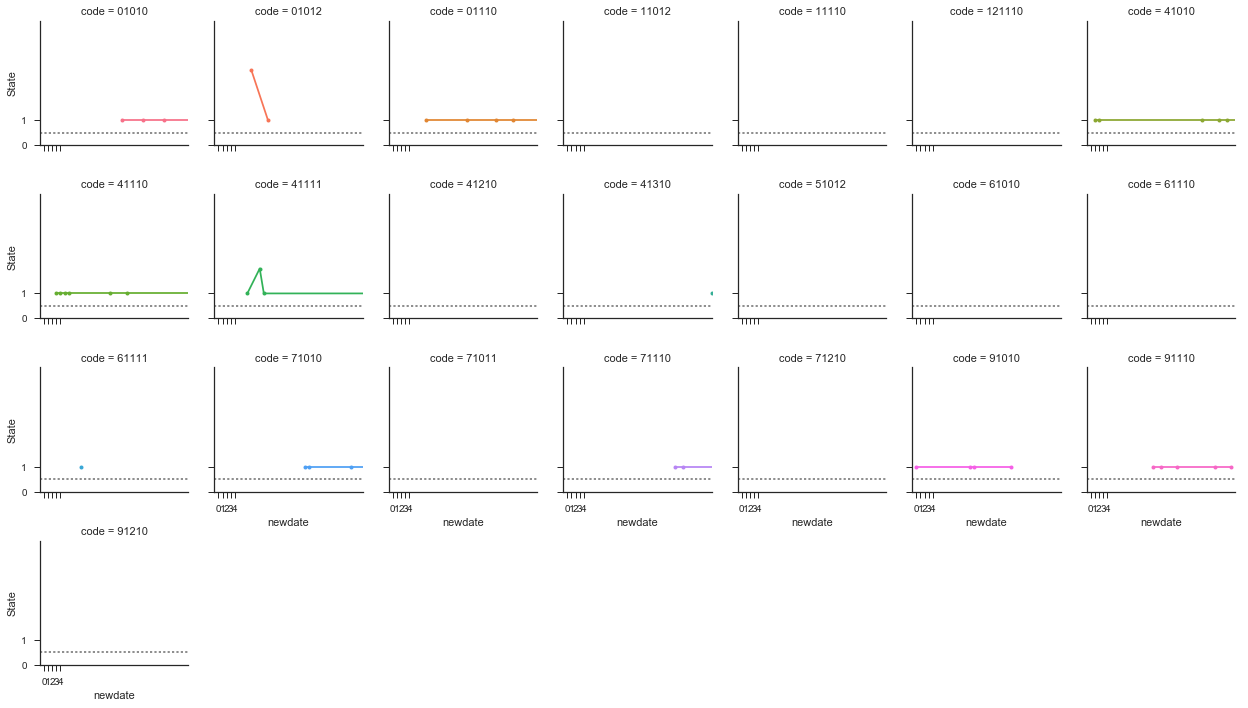

In [114]:
# Create a dataset with many short random walks
rs = np.random.RandomState(4)
pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
pos -= pos[:, 0, np.newaxis]
step = np.tile(range(5), 20)
walk = np.repeat(range(20), 5)

sns.set(style="ticks")
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(pvt1, col="code", hue="code", col_wrap=7, size=2.5)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=.5, ls=":", c=".5")

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, "newdate", "State", marker="o", ms=4)

# Adjust the tick positions and labels
#xlim is the date factorized
grid.set(xticks=np.arange(5), yticks=[0, 1],
         xlim=(-1, 35), ylim=(0, 5))

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1.15)



##### <b>Male Murders: Age Group 2 - 6 to 17</b>

In [132]:
def agedata(col):
    m1 = m_analyze.loc[(m_analyze['age_group'] == col)&(m_analyze['State'] == 'New York')]
    pvt = pd.pivot_table(m1,index=["Date_", "City", "code"],values=["State"],aggfunc=lambda x: len(x))
    pvt1 = pvt.reset_index()
    pvt1['newdate'] = pd.factorize(pvt1['Date_'])[0]
    #return pvt1

    # Create a dataset with many short random walks
    rs = np.random.RandomState(4)
    pos = rs.randint(-1, 2, (20, 5)).cumsum(axis=1)
    pos -= pos[:, 0, np.newaxis]
    step = np.tile(range(5), 20)
    walk = np.repeat(range(20), 5)

    sns.set(style="ticks")
    # Initialize a grid of plots with an Axes for each walk
    grid = sns.FacetGrid(pvt1, col="code", hue="code", col_wrap=7, size=2.5)

    # Draw a horizontal line to show the starting point
    grid.map(plt.axhline, y=.5, ls=":", c=".5")

    # Draw a line plot to show the trajectory of each random walk
    grid.map(plt.plot, "newdate", "State", marker="o", ms=4)

    # Adjust the tick positions and labels
    #xlim is the date factorized
    grid.set(xticks=np.arange(5), yticks=[0, 1],
         xlim=(-1, 35), ylim=(0, 10))

    # Adjust the arrangement of the plots
    grid.fig.tight_layout(w_pad=1.15)

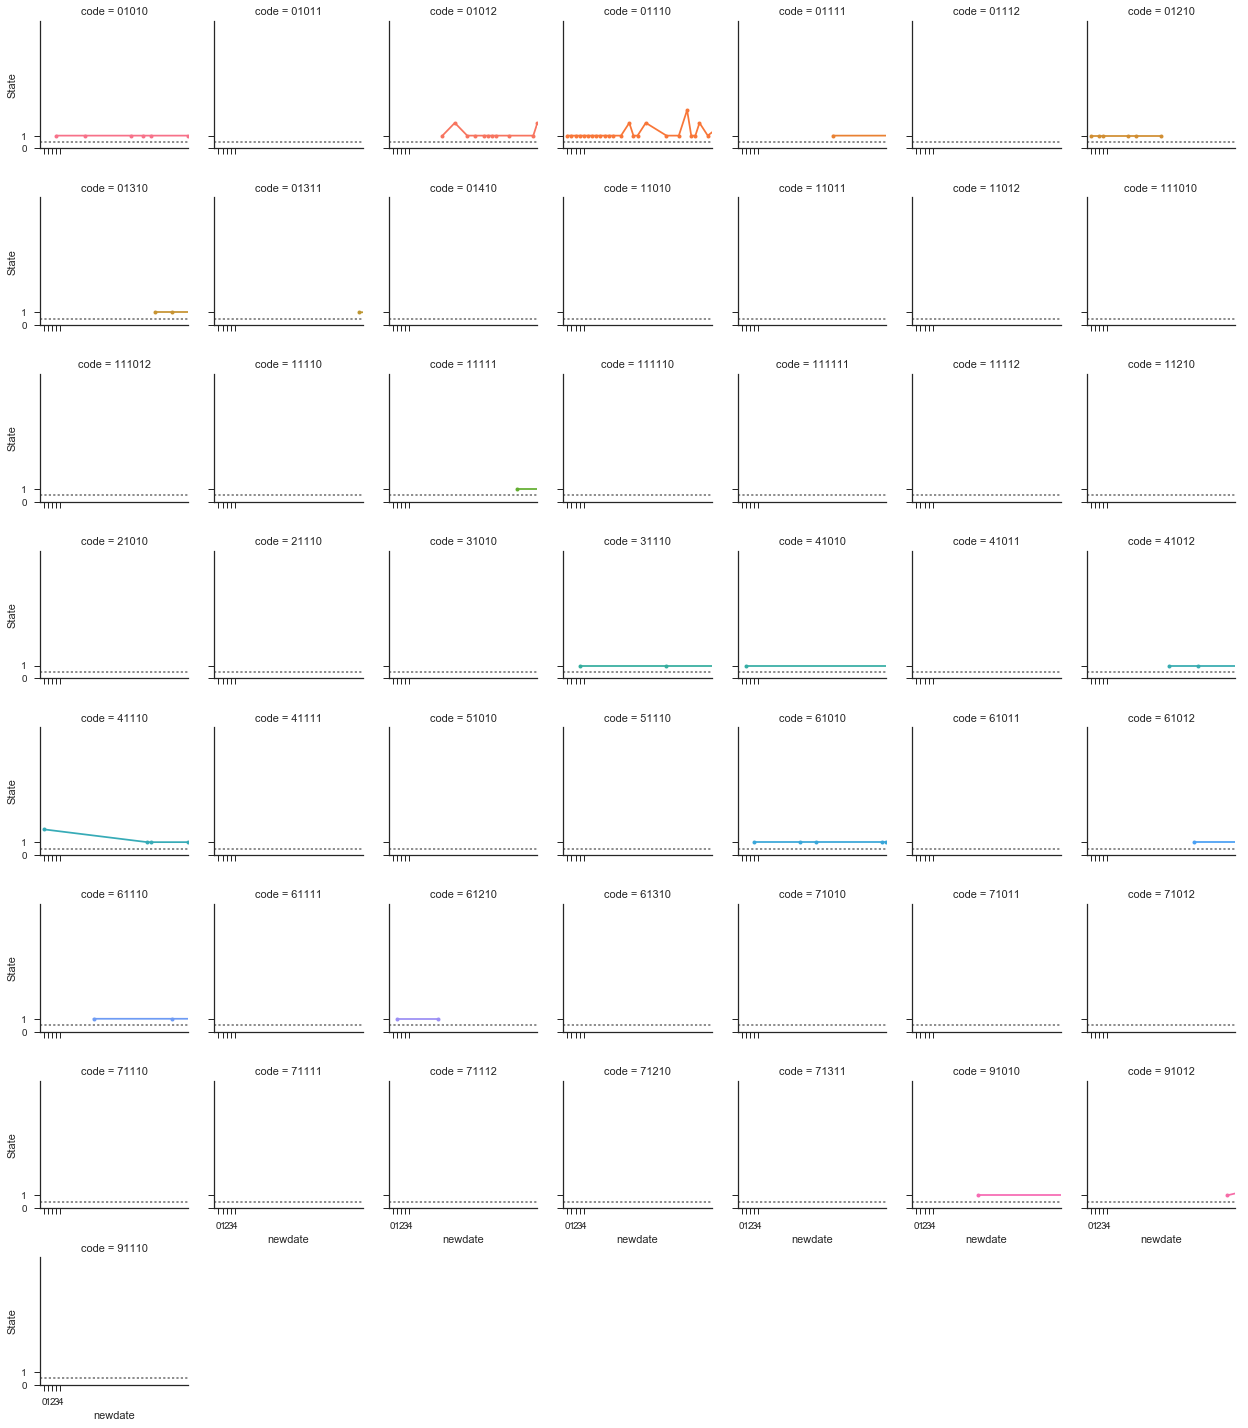

In [133]:
#Males 5 - 17 yo 
agedata('ag2')

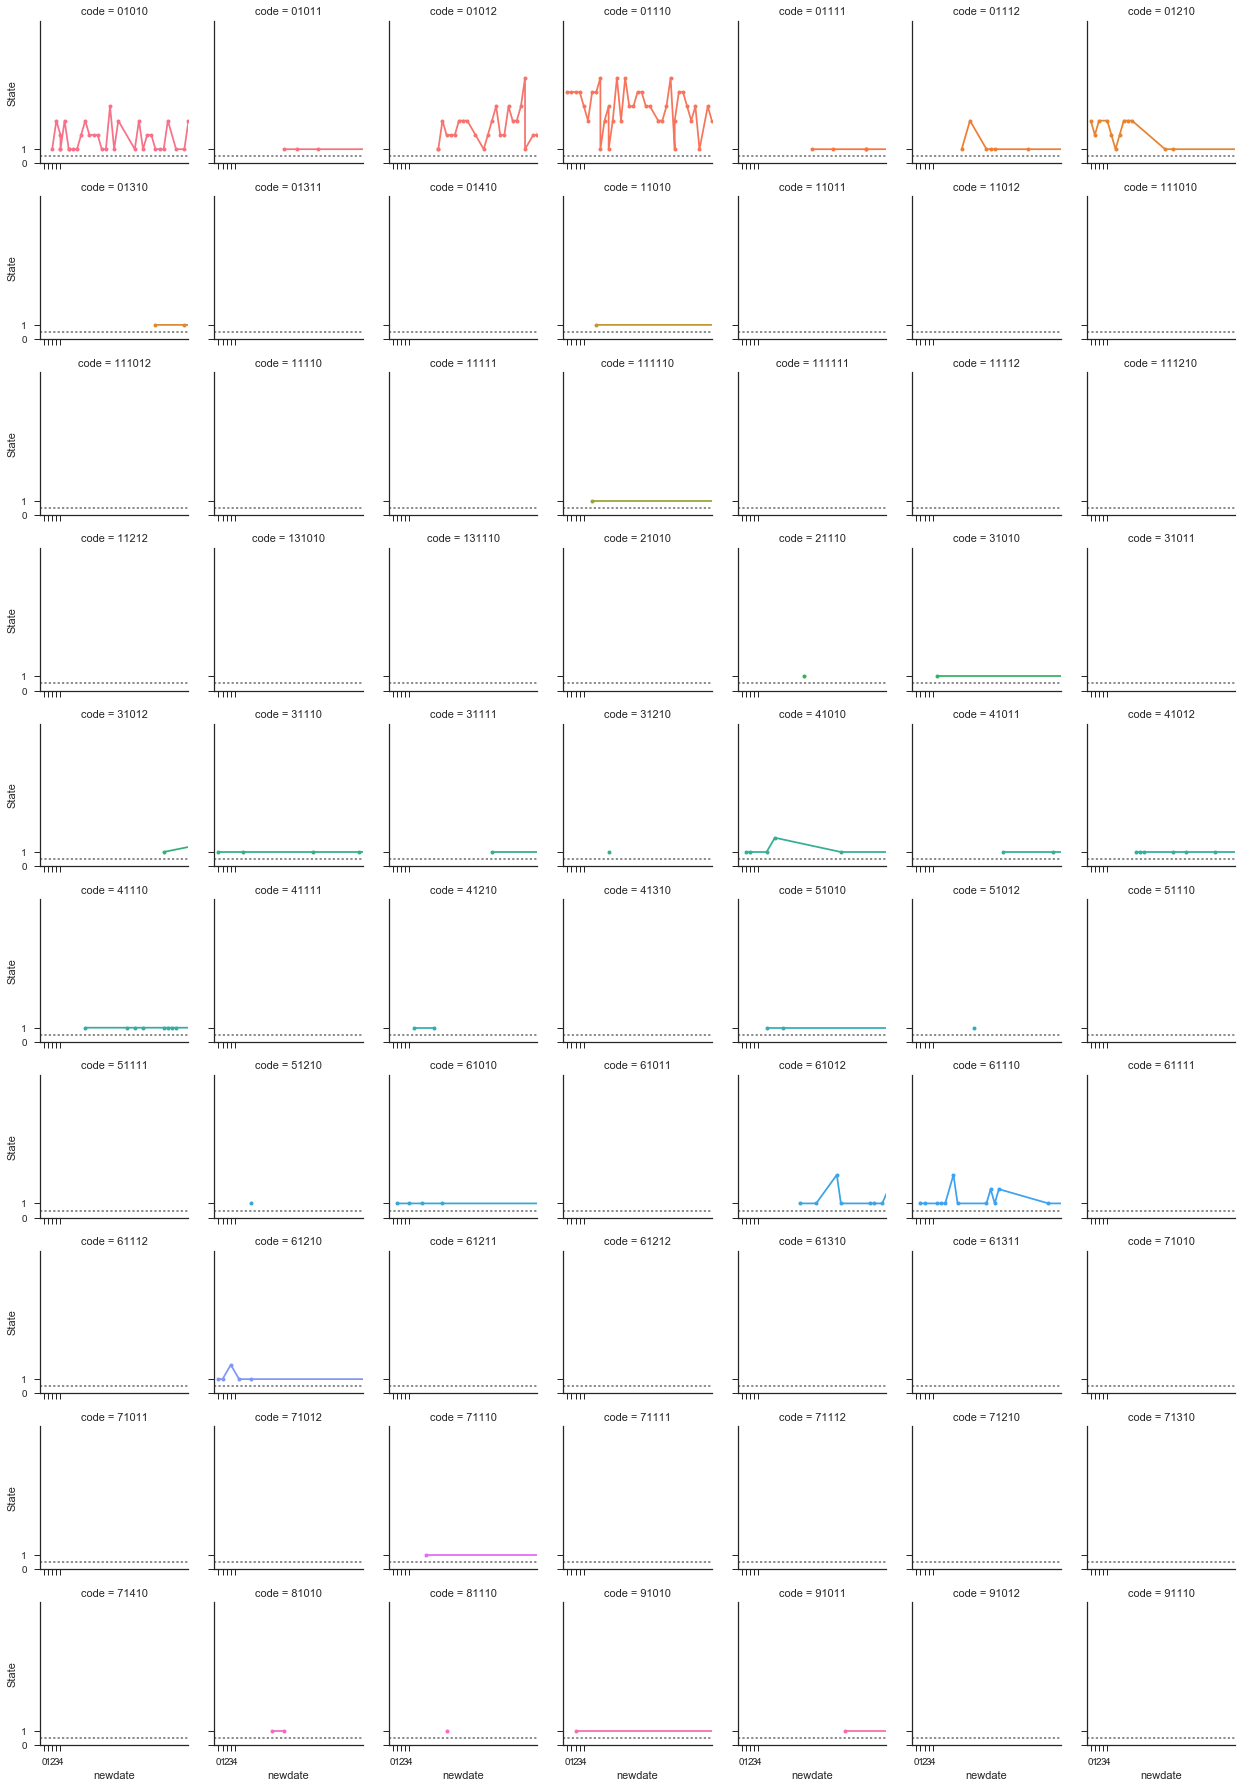

In [134]:
#Males 18 - 24
agedata('ag3')

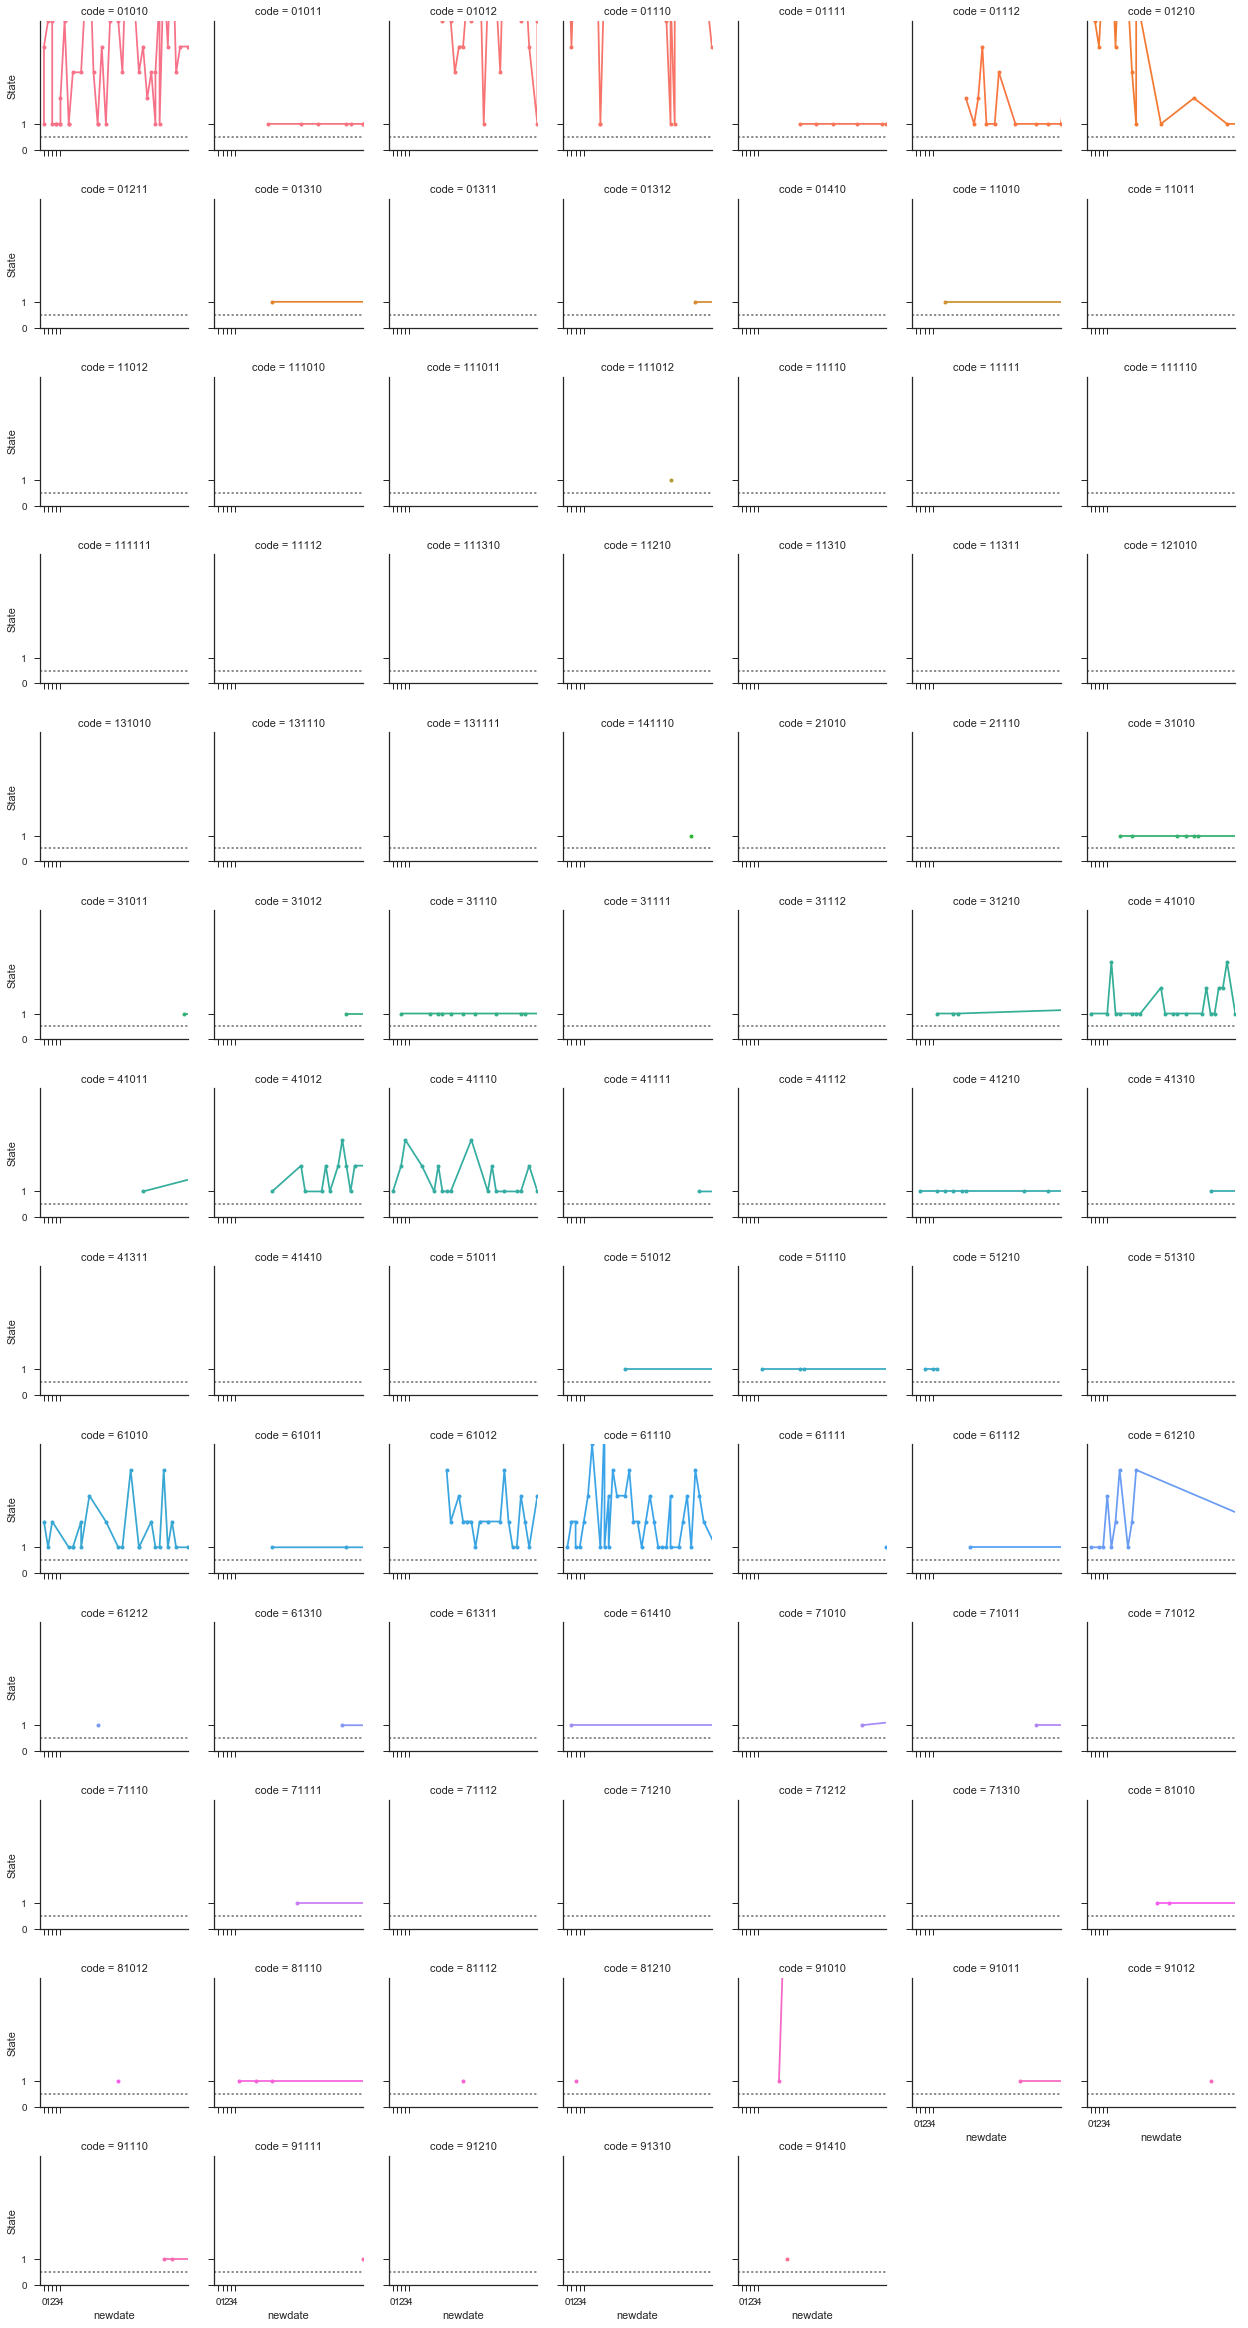

In [131]:
#Males 25 - 44
agedata('ag4')